## Simeple Baseline - Weather doesn't change
To evalute a forecast of a trained model a baseline is needed. This document containes the first simple baseline, which assumes that the weather will remain as it is.<br> 
The results of this simple basline are displayed in two confusion matrices for 5/35 minutes forecast. 

### Extract Test Pictures
The radar images from 2016 and 2017 are used to test the baselines. Therefore the picture get extracted if this wasn't done before.
Before executing this script, the zipped .pngs have to be downloaded and stored in the following structure: 

```
.
├── Data
│   └── TestPicturesZipped
│       ├── 2016
│       │   ├── radar_1601.zip
│       │   ├── radar_1602.zip
│       │   ├── radar_1603.zip
│       │   ├── radar_1604.zip
│       │   ├── radar_1605.zip
│       │   ├── radar_1606.zip
│       │   ├── radar_1607.zip
│       │   ├── radar_1608.zip
│       │   ├── radar_1609.zip
│       │   ├── radar_1610.zip
│       │   ├── radar_1611.zip
│       │   └── radar_1612.zip
│       └── 2017
│           ├── radar_1701.zip
│           ├── radar_1702.zip
│           ├── radar_1703.zip
│           ├── radar_1704.zip
│           ├── radar_1705.zip
│           ├── radar_1706.zip
│           ├── radar_1707.zip
│           ├── radar_1708.zip
│           ├── radar_1709.zip
│           ├── radar_1710.zip
│           ├── radar_1711.zip
│           └── radar_1712.zip
├── README.md
└── SimpleBaseline.ipynb
```

In [1]:
import zipfile
import os
abs_dir_path = os.path.join(os.path.join(os.path.abspath('.')))
data_dir = os.listdir(abs_dir_path + "/Data")

if "TestPictures" not in data_dir:
    print("Pictures get extracted")
    list_years = os.listdir(abs_dir_path + "/Data/TestPicturesZipped")
    list_years.sort()
    for year in list_years:
        list_of_months = os.listdir(abs_dir_path + "/Data/TestPicturesZipped/" + year)
        list_of_months.sort()
        for month in list_of_months:   
            with zipfile.ZipFile(abs_dir_path + "/Data/TestPicturesZipped/" + year + "/" + month) as zip_ref:
                zip_ref.extractall(abs_dir_path + "/Data/TestPictures/" + year + "/" + month.replace(".zip", ""))
else: 
    print("Folder already exists")

Folder already exists


### Get the path to every picture
The path to every test picure of the years 2016 and 2017 are stored in *paths_to_test_pics*

In [2]:
print("Path to test pictures get stored")
list_years = os.listdir(abs_dir_path + "/Data/TestPictures")
list_years.sort()
paths_to_test_pics = []
for year in list_years:
    list_of_months = os.listdir(abs_dir_path + "/Data/TestPictures/" + year)
    list_of_months.sort()
    for month in list_of_months:
        path_to_pics_of_month = os.listdir(abs_dir_path + "/Data/TestPictures/" + year + "/" + month)
        path_to_pics_of_month.sort()
        for path in path_to_pics_of_month:
            paths_to_test_pics.append(abs_dir_path + "/Data/TestPictures/" + year + "/" + month + "/" + path)
print(paths_to_test_pics[0]) 
print(len(paths_to_test_pics))

Path to test pictures get stored
/home/paul/Documents/Master1/DeepRain_Teamproject/DeepRain2/Data/TestPictures/2016/radar_1601/scaled_1601010000.png
210528


### Get every constance pixel value 
The get the pixel value a section of each picture is read and resized (64x64).<br>
The values are stored as shown below:<br>
[pic_path, pixel_value]


Since this takes quite a while the result is stored in the file *pixel_of_constance2016_17.p*. The calculation is skipped if the file already exists. 

In [3]:
def get_pixel_of_constance(pic_path):
    pic = io.imread(pic_path)[820:1020, 400:600]
    pic_transformed = transform.resize(pic, output_shape = (64,64))
    pixel_of_constance = pic_transformed[posx, posy]
    return pixel_of_constance

In [4]:
from skimage import io, transform
import numpy as np
import pickle
import time

data_dir = os.listdir(abs_dir_path)

if "pixel_of_constance2016_17.p" not in data_dir:
    #Postition of Constance: X 31, Y 40
    posx, posy = 31, 40,
    counter = 1
    pixel_of_constance = []
    start_time = time.time()
    for pic_path in paths_to_test_pics:
        pixel_of_constance.append([pic_path, get_pixel_of_constance(pic_path)]) 
        if paths_to_test_pics.index(pic_path)%1000 == 0 and paths_to_test_pics.index(pic_path) != 0:
            print(str(counter*1000) + " done")
            print("--- %s seconds ---" % (time.time() - start_time))
            start_time = time.time()
            counter +=1

    pickle.dump(pixel_of_constance, open("pixel_of_constance2016_17.p", "wb"))
else: 
    print("File already exists")

File already exists


In [5]:
pixel_of_constance1617 = pickle.load(open("pixel_of_constance2016_17.p", "rb"))
print("Length of List: " + str(len(pixel_of_constance1617)))
pixel_of_constance1617[0]

Length of List: 210528


['/home/paul/Documents/Master1/DeepRain_Teamproject/DeepRain2/Data/TestPictures/2016/radar_1601/scaled_1601010000.png',
 0.0]

### Calclate mean rain intensity 
For later catigorization the mean rain intensity get calculated.<br>
Before each 0 (no rain) value gets removed.

In [6]:
# calculate the mean rain intensity for later categorization.
pixel_of_constance1617 = np.asanyarray(pickle.load(open("pixel_of_constance2016_17.p", "rb")))[:,1].astype(np.float)
pixel_of_constance1617_without_0 = [pixel_value for pixel_value in pixel_of_constance1617 if pixel_value != 0]
mean_rain_intensity = np.mean(pixel_of_constance1617_without_0)
print("Mean Rain Intensity: " + str(mean_rain_intensity))


Mean Rain Intensity: 0.01769569238789092


### Get predictions and confusion matrix
The following functions are used the get the predictions either for three or for two categories.<br>
Afterwards a confusion matrix is calculated and shown.

In [7]:
def get_prediction_3_cat(forecast_in_5_min_steps, filename):
    '''
    This function calculates the forecast for a given time in three categories. 
    0 : no rain 
    1 : rain below mean 
    2 : rain above mean
    
    forecast_in_5_min_steps: Time in 5 Minute steps for the prediction (e.g. 5 or 35)
    filename: Name of file where Pixel of Contance is stored as [pic_path, pixel_value] (e.g. "pixel_of_constance2016_17.p")
    Returns:
    forcasts: [prediction, actual_weather]
    '''
    
    pixel_of_constance = pickle.load(open(filename, "rb"))
    forecast_pic_distance = int(forecast_in_5_min_steps/5)
    forecasts = []
    for index in range(len(pixel_of_constance)-(forecast_pic_distance)):
        #get Constance Pixelvalue and make a Prediction
        first_pixel_value = pixel_of_constance[index][1]
        if first_pixel_value == 0:
            #print("It will not rain")
            prediction = 0
        elif first_pixel_value < mean_rain_intensity/2:
            #print("It will rain a little bit")
            prediction = 1
        else:
            #print("It will rain")
            prediction = 2


        # Compare with actuale weather
        second_pixel_value = pixel_of_constance[index+forecast_pic_distance][1]
        if second_pixel_value == 0:
            #print("no rain")
            actual_weather = 0
        elif second_pixel_value < mean_rain_intensity/2:
            #print("little rain")
            actual_weather = 1
        else:
            #print("rain")
            actual_weather = 2
        forecasts.append([prediction, actual_weather])
    return forecasts

In [8]:
def get_prediction_2_cat(forecast_in_5_min_steps, filename):
    '''
    This function calculates the forecast for a given time in two categories. 
    0 : no rain 
    1 : rain
    
    forecast_in_5_min_steps: Time in 5 Minute steps for the prediction (e.g. 5 or 35)
    filename: Name of file where Pixel of Contance is stored as [pic_path, pixel_value] (e.g. "pixel_of_constance2016_17.p")
    Returns:
    forcasts: [prediction, actual_weather]
    '''
    
    pixel_of_constance = pickle.load(open(filename, "rb"))
    forecast_pic_distance = int(forecast_in_5_min_steps/5)
    forecasts = []
    for index in range(len(pixel_of_constance)-(forecast_pic_distance)):
        #get Constance Pixelvalue and make a Prediction
        first_pixel_value = pixel_of_constance[index][1]
        if first_pixel_value == 0:
            #print("It will not rain")
            prediction = 0
        else:
            #print("It will rain")
            prediction = 1


        # Compare with actuale weather
        second_pixel_value = pixel_of_constance[index+forecast_pic_distance][1]
        if second_pixel_value == 0:
            #print("no rain")
            actual_weather = 0
        else:
            #print("rain")
            actual_weather = 1
        forecasts.append([prediction, actual_weather])
    return forecasts

In [9]:
# taken from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [10]:
def con_ma_3_and_2_cat(forecast, classes):
    #absolute
    plot_confusion_matrix(np.asanyarray(forecast)[:,1], np.asanyarray(forecast)[:,0], classes)
    plt.show()

    #normalized
    plot_confusion_matrix(np.asanyarray(forecast)[:,1], np.asanyarray(forecast)[:,0], classes, normalize=True)
    plt.show()
    

Confusion Matrix for 5 min Forcast
3 Categories
Confusion matrix, without normalization


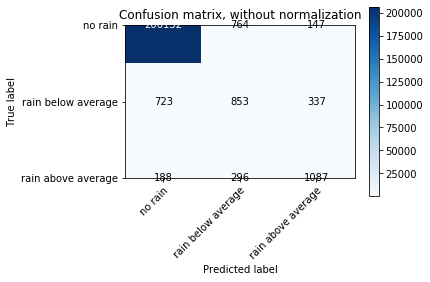

Normalized confusion matrix


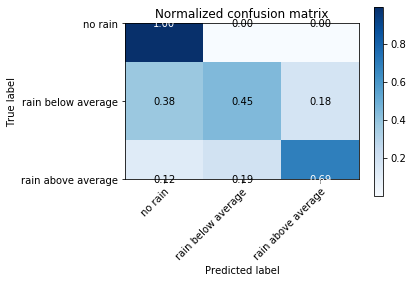

2 Categories
Confusion matrix, without normalization


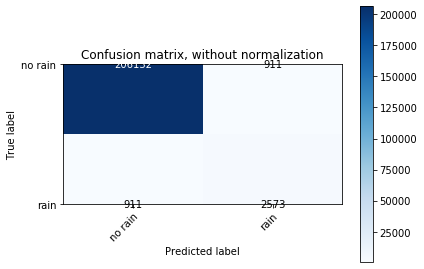

Normalized confusion matrix


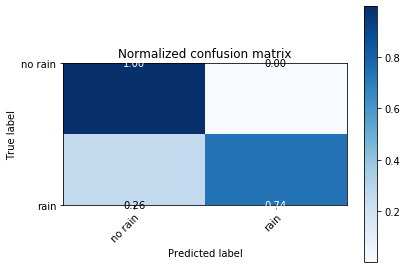

Confusion Matrix for 35 min Forcast
3 Categories
Confusion matrix, without normalization


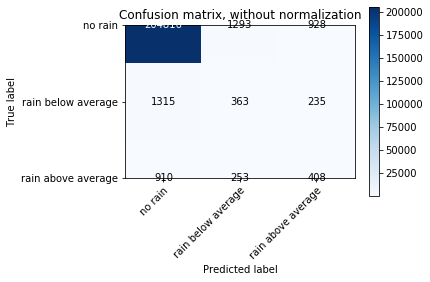

Normalized confusion matrix


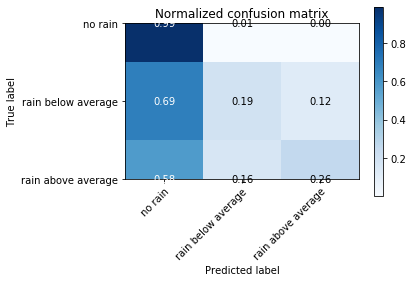

2 Categories
Confusion matrix, without normalization


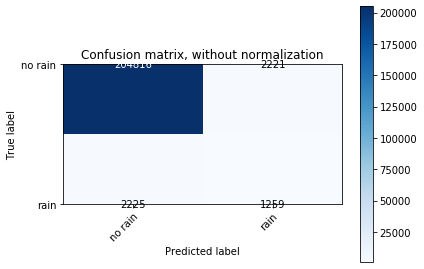

Normalized confusion matrix


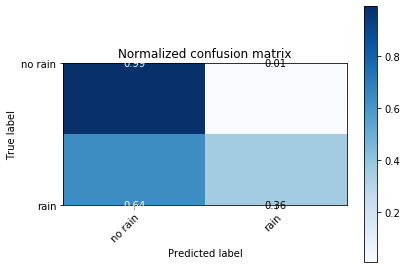

In [11]:
# calculate the forecast for 5 min in 3 categories 
print("Confusion Matrix for 5 min Forcast")
print("3 Categories")
forecast = get_prediction_3_cat(forecast_in_5_min_steps=5, filename="pixel_of_constance2016_17.p")
con_ma_3_and_2_cat(forecast, np.asanyarray(["no rain", "rain below average", "rain above average"]))
                   
print("2 Categories")
forecast = get_prediction_2_cat(forecast_in_5_min_steps=5, filename="pixel_of_constance2016_17.p")
con_ma_3_and_2_cat(forecast, np.asanyarray(["no rain", "rain"]))                

print("Confusion Matrix for 35 min Forcast")
print("3 Categories")
forecast = get_prediction_3_cat(forecast_in_5_min_steps=35, filename="pixel_of_constance2016_17.p")
con_ma_3_and_2_cat(forecast, np.asanyarray(["no rain", "rain below average", "rain above average"]))
                   
print("2 Categories")
forecast = get_prediction_2_cat(forecast_in_5_min_steps=35, filename="pixel_of_constance2016_17.p")
con_ma_3_and_2_cat(forecast, np.asanyarray(["no rain", "rain"]))    
